# PAI CA1 Group 7

### Importing Libaries

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.feature_selection import chi2

## Loading Dataset

In [2]:
%%time
file_path = './dataset/taxi_data.csv'
chunksize = 10 ** 6
with pd.read_csv(file_path, chunksize=chunksize) as reader:
    df = pd.concat([chunk for chunk in reader])

df.head()

CPU times: total: 6.3 s
Wall time: 8.79 s


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.0,143.3,-1.706,-9.271,-1.209,-0.0290,-0.0327,0.0154,2.0,0.00,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
1,0,8.0,143.3,-1.417,-9.548,-1.861,-0.0224,0.0050,-0.0258,3.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
2,0,8.0,143.3,-0.347,-9.533,-1.205,0.0150,-0.0500,0.0251,9.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
3,0,8.0,143.3,-0.601,-9.452,-2.158,0.0045,-0.0117,-0.0041,11.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
4,0,8.0,143.3,-0.598,-9.863,-1.673,-0.0004,0.0003,-0.0098,12.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20


In [3]:
df.shape

(7346552, 20)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7346552 entries, 0 to 7346551
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  driver_id       int64  
 12  label           int64  
 13  driver_name     object 
 14  years_of_exp    int64  
 15  gender          object 
 16  car_brand       object 
 17  driver_rating   float64
 18  age             int64  
 19  age_of_car      int64  
dtypes: float64(11), int64(6), object(3)
memory usage: 1.1+ GB


#### Double Checking whether there is any NULL or missing values

In [5]:
rows, columns = df.shape

num_null_rows = df.isna().any(axis=1).sum()
pct_null_rows = num_null_rows / rows

print(f'No. of rows with at least one missing value: {num_null_rows}')
print(f'Percentage of rows with at least one missing value: {round((pct_null_rows) * 100, 2)}%')

No. of rows with at least one missing value: 0
Percentage of rows with at least one missing value: 0.0%


### Setting up for Analysis

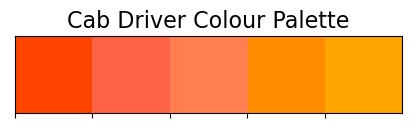

In [6]:
# set colour palette for better visualisations
palette = ['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA500']

sns.palplot(palette)
plt.title('Cab Driver Colour Palette', fontsize=16)
plt.grid(False)
plt.show()

## Exploratory Data Analysis
As we have done our data cleaning and preprocessing in SQL, we can now perform some exploratory data analysis on our dataset

In [7]:
%%time
# We will be using dask to read in the data as it is faster than pandas
dask_df = dd.read_csv(file_path)
dask_df =  dask_df.persist() # persist the data in memory
dask_df.head()

CPU times: total: 2.28 s
Wall time: 4.65 s


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.0,143.3,-1.706,-9.271,-1.209,-0.0290,-0.0327,0.0154,2.0,0.00,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
1,0,8.0,143.3,-1.417,-9.548,-1.861,-0.0224,0.0050,-0.0258,3.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
2,0,8.0,143.3,-0.347,-9.533,-1.205,0.0150,-0.0500,0.0251,9.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
3,0,8.0,143.3,-0.601,-9.452,-2.158,0.0045,-0.0117,-0.0041,11.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20
4,0,8.0,143.3,-0.598,-9.863,-1.673,-0.0004,0.0003,-0.0098,12.0,0.23,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.7,53,20


## Descriptive Analysis

In [8]:
dask_df.compute().shape

(7346552, 20)

In [9]:
dask_df.compute().isna().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
driver_id         0
label             0
driver_name       0
years_of_exp      0
gender            0
car_brand         0
driver_rating     0
age               0
age_of_car        0
dtype: int64

In [10]:
unqiue_values = dask_df.nunique().compute().sort_values(ascending=False)
unqiue_values

acceleration_y    59261
gyro_y            57633
Bearing           53208
acceleration_z    52095
gyro_x            44536
acceleration_x    43637
gyro_z            43417
bookingID         20000
speed              9946
Accuracy           9492
second             6198
driver_id           500
driver_name         500
age_of_car           38
driver_rating        31
years_of_exp         21
age                  14
car_brand            12
label                 2
gender                2
dtype: int64

## Summary Statistics

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dask_df.describe().compute().T

,count,mean,std,min,25%,50%,75%,max
bookingID,7346552.000,818325455111.994,495325235467.501,0.000,506806140972.000,884763263111.000,1305670058069.000,1709396983975.000
Accuracy,7346552.000,11.617,87.169,0.000,3.900,4.550,8.000,6070.100
Bearing,7346552.000,168.932,107.200,0.000,80.310,173.000,266.000,360.000
acceleration_x,7346552.000,0.069,1.420,-38.984,-0.466,0.086,0.663,66.873
acceleration_y,7346552.000,4.466,8.130,-57.800,1.853,9.175,9.738,61.159
acceleration_z,7346552.000,0.896,3.251,-78.448,-0.790,0.953,3.010,78.056
gyro_x,7346552.000,-0.002,0.143,-48.456,-0.025,-0.000,0.025,30.709
gyro_y,7346552.000,0.000,0.335,-57.345,-0.029,0.001,0.033,80.315
gyro_z,7346552.000,-0.000,0.147,-53.554,-0.018,0.000,0.019,45.060
second,7346552.000,3720.743,1389856.188,0.000,248.000,533.000,889.000,619317000.000


## Reducing Memory of our dataframe

In [12]:
dask_df.compute().info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 7346552 entries, 0 to 526009
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  driver_id       int64  
 12  label           int64  
 13  driver_name     object 
 14  years_of_exp    int64  
 15  gender          object 
 16  car_brand       object 
 17  driver_rating   float64
 18  age             int64  
 19  age_of_car      int64  
dtypes: float64(11), int64(6), object(3)
memory usage: 2.3 GB


We can see that our memory load for our pandas dataframe is at 2.3GB, so we are going to shrink the memory load using some techniques

In [13]:
convert_dict = {
    'driver_id': 'int32',
    'label': 'category',
    'gender': 'category',
    'years_of_exp': 'int16',
    'age': 'int16',
    'age_of_car': 'int16'
}

# Convert the columns to the specified types
df_new = dask_df.compute().astype(convert_dict)
df_new.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 7346552 entries, 0 to 526009
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   bookingID       int64   
 1   Accuracy        float64 
 2   Bearing         float64 
 3   acceleration_x  float64 
 4   acceleration_y  float64 
 5   acceleration_z  float64 
 6   gyro_x          float64 
 7   gyro_y          float64 
 8   gyro_z          float64 
 9   second          float64 
 10  speed           float64 
 11  driver_id       int32   
 12  label           category
 13  driver_name     object  
 14  years_of_exp    int16   
 15  gender          category
 16  car_brand       object  
 17  driver_rating   float64 
 18  age             int16   
 19  age_of_car      int16   
dtypes: category(2), float64(11), int16(3), int32(1), int64(1), object(2)
memory usage: 1.7 GB


We have successfully shrunked our memory by around 600MBs

In [14]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
bookingID,7346552.000,818325455111.994,495325235467.501,0.000,377957122216.000,807453851664.000,1254130450446.000,1709396983975.000
Accuracy,7346552.000,11.617,87.169,0.000,3.900,4.260,8.000,6070.100
Bearing,7346552.000,168.932,107.200,0.000,78.000,168.690,262.390,360.000
acceleration_x,7346552.000,0.069,1.420,-38.984,-0.507,0.061,0.633,66.873
acceleration_y,7346552.000,4.466,8.130,-57.800,-2.027,9.082,9.709,61.159
acceleration_z,7346552.000,0.896,3.251,-78.448,-0.929,0.777,2.752,78.056
gyro_x,7346552.000,-0.002,0.143,-48.456,-0.027,-0.001,0.023,30.709
gyro_y,7346552.000,0.000,0.335,-57.345,-0.030,0.000,0.031,80.315
gyro_z,7346552.000,-0.000,0.147,-53.554,-0.019,0.000,0.018,45.060
second,7346552.000,3720.743,1389856.188,0.000,241.000,520.000,862.000,619317000.000


## Checking for Outliers

In [15]:
continuous_cols  = df_new.select_dtypes(include=['int16', 'int32','int64','float64']).columns.drop(['bookingID', 'driver_id'])
continuous_cols 

Index(['Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'speed',
       'years_of_exp', 'driver_rating', 'age', 'age_of_car'],
      dtype='object')

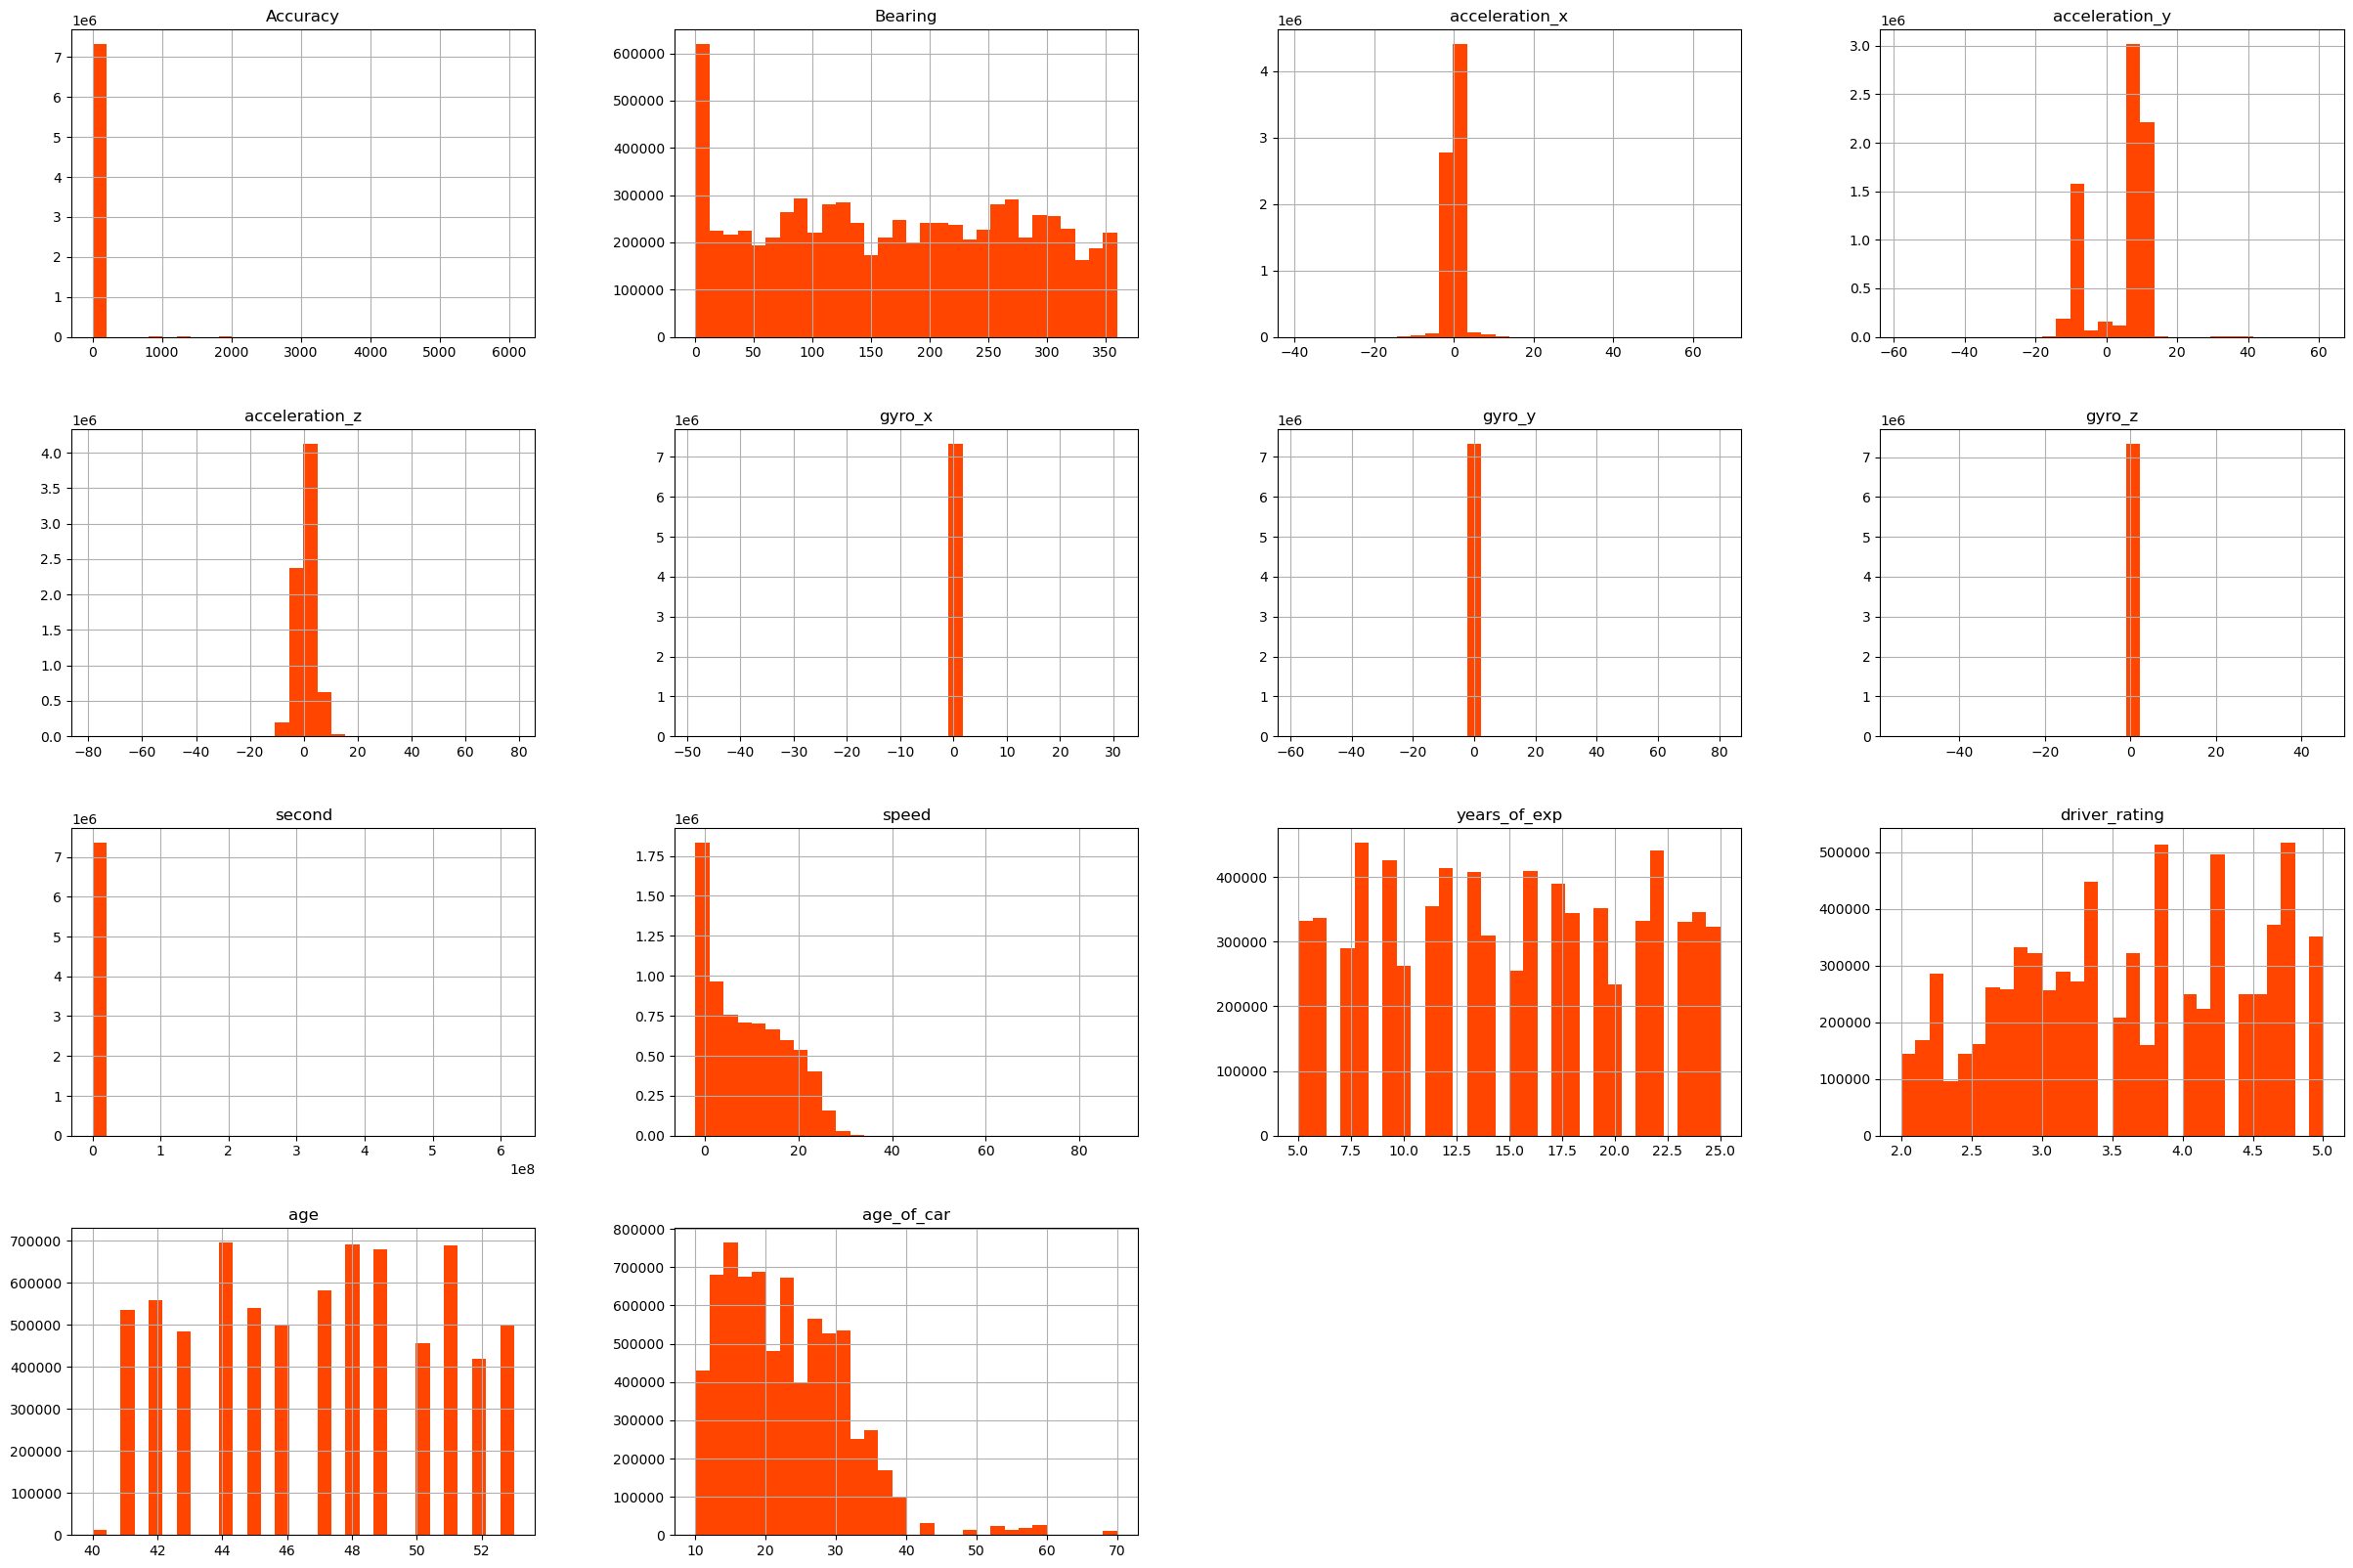

In [16]:
df_new[continuous_cols ].hist(figsize=(30, 20), bins=30, color=palette[0])
plt.show()

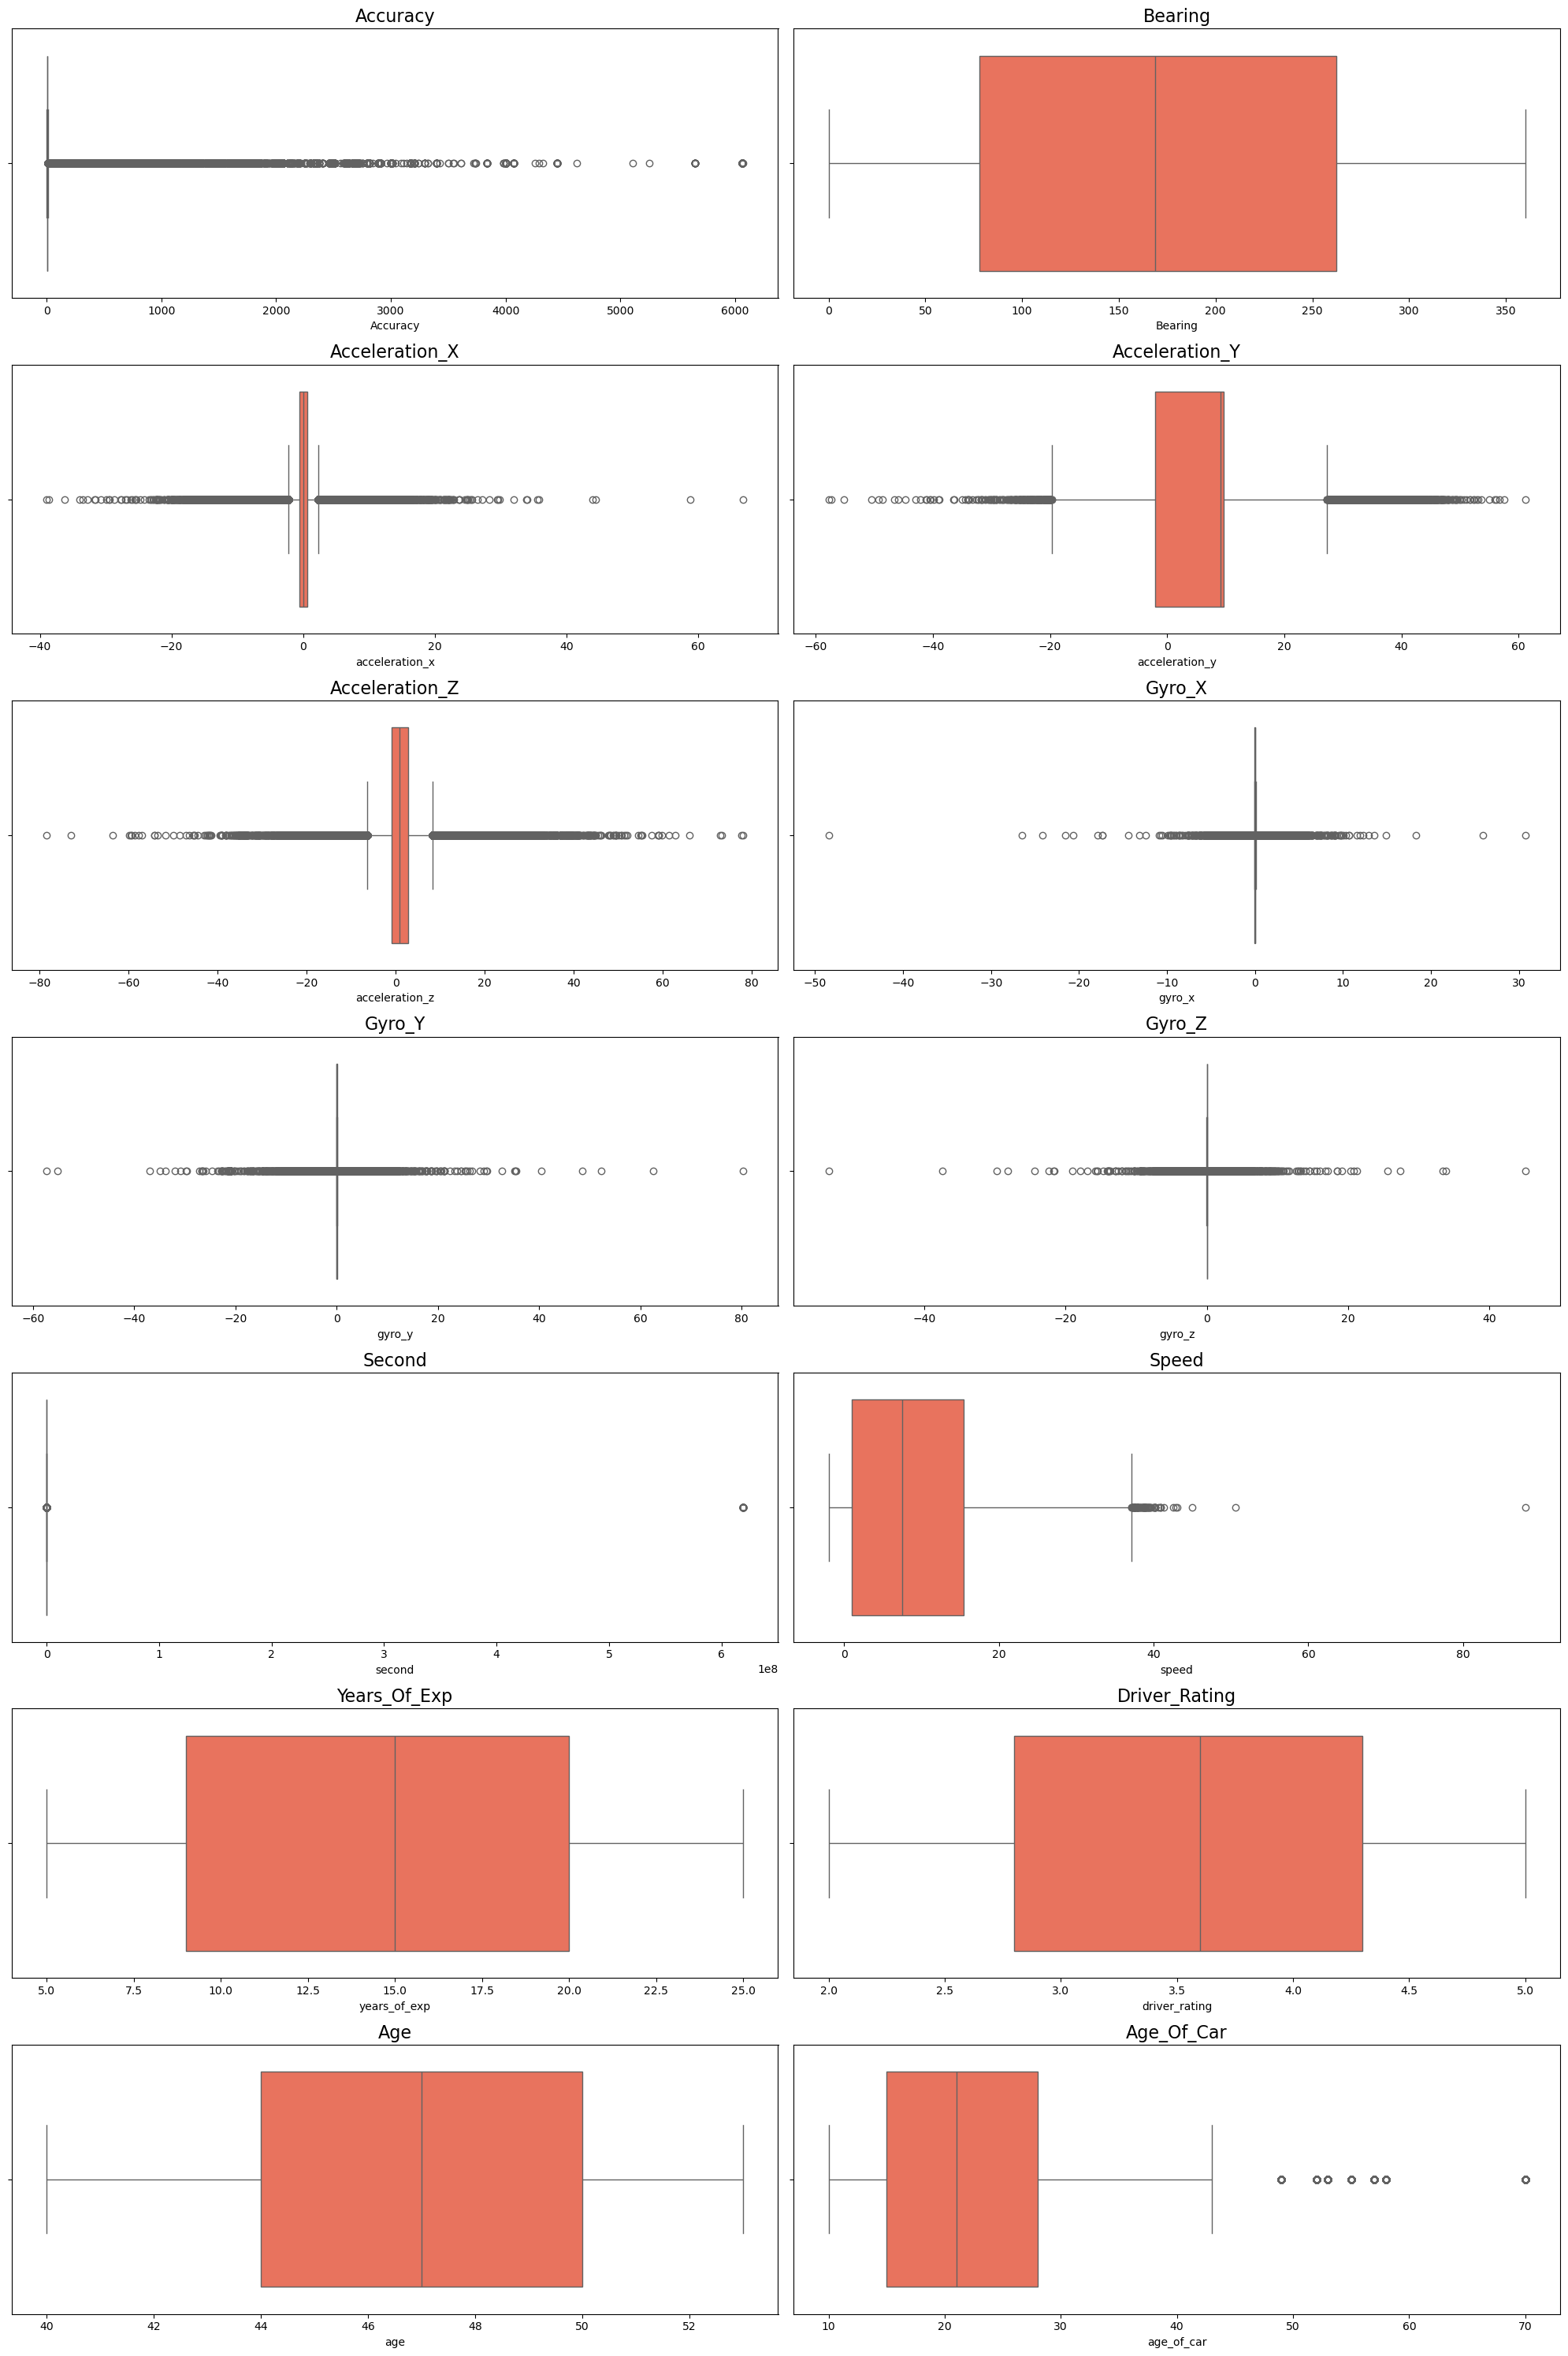

In [17]:
import math
num_cols = 2
num_rows = math.ceil(len(continuous_cols) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=col, data=df_new, ax=axes[i], color=palette[1])
    axes[i].set_title(f'{col.title()}', fontsize=16)

plt.tight_layout()
plt.show()

### Checking for any inconsistences on our data

#### Seconds
When we observe our boxplot for seconds, we notice a huge outlier that affects the entire distribution of our data

In [18]:
# checking for rides greater than 6 hours (21600 seconds)
seconds_outlier = len(df_new[df_new['second'] > 21600])
total_rows = len(df_new)
pct_outlier = seconds_outlier / total_rows
outlier_booking_ids = df_new[df_new['second'] > 21600]['bookingID'].unique()
print(f'Total Number of rows with anomalies {seconds_outlier}')
print(f'Percentage of rows with anomalous seconds: {round(pct_outlier * 100,8)}%')
print(f'Anomalous Values: {df_new[df_new["second"] > 21600]["second"].unique()}')
print(f'BookingIDs with anomalous seconds: {outlier_booking_ids}')

Total Number of rows with anomalies 37
Percentage of rows with anomalous seconds: 0.00050364%
Anomalous Values: [6.19316e+08 6.19315e+08 6.19317e+08]
BookingIDs with anomalous seconds: [1108101562401 1434519076976 1460288880770  858993459333]


It is practically impossible for rides to be 173,032 Hrs long. This anomaly may be attributed to errors within the sensor of the taxi as there is multiple of the same second anomaly in different bookingIDs.

In [19]:
df_new

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,driver_id,label,driver_name,years_of_exp,gender,car_brand,driver_rating,age,age_of_car
0,0,8.000,143.300,-1.706,-9.271,-1.209,-0.029,-0.033,0.015,2.000,0.000,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
1,0,8.000,143.300,-1.417,-9.548,-1.861,-0.022,0.005,-0.026,3.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
2,0,8.000,143.300,-0.347,-9.533,-1.205,0.015,-0.050,0.025,9.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
3,0,8.000,143.300,-0.601,-9.452,-2.158,0.004,-0.012,-0.004,11.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
4,0,8.000,143.300,-0.598,-9.863,-1.673,-0.000,0.000,-0.010,12.000,0.230,359,0,Jemmie Cardew,9,Female,Mercedes-Benz,4.700,53,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526005,996432412828,3.710,87.000,-1.908,8.988,2.710,-0.105,0.443,0.059,1538.000,3.570,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526006,996432412828,3.650,64.000,-0.910,8.722,2.320,-0.121,0.333,0.090,1539.000,2.980,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526007,996432412828,3.460,42.000,-2.490,9.491,-0.503,0.061,0.327,0.043,1540.000,2.390,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11
526008,996432412828,3.620,3.000,-1.499,10.147,-0.668,0.135,0.243,0.093,1542.000,3.790,420,1,Ringo Wegenen,9,Male,Toyota,3.900,49,11


## Statistical Tests
We will be doing 2 statisical tests
- Point Biserial Correlation between label and numerical columns
- Chi-squared Test for Correlation between label and nominal variables (eg. car brand)

### Point Biserial Correlation

In [20]:
for col in continuous_cols:
    correlation = stats.pointbiserialr(df_new["label"], df_new[col]).statistic
    print(f'\nCorrelation between label and {col}:')
    print(f'{format(correlation, ".7f")}')


Correlation between label and Accuracy:
0.0090113

Correlation between label and Bearing:
-0.0092208

Correlation between label and acceleration_x:
0.0000673

Correlation between label and acceleration_y:
-0.0116930

Correlation between label and acceleration_z:
0.0133494

Correlation between label and gyro_x:
0.0025999

Correlation between label and gyro_y:
-0.0015192

Correlation between label and gyro_z:
0.0006110

Correlation between label and second:
-0.0014187

Correlation between label and speed:
-0.0328562

Correlation between label and years_of_exp:
-0.0113472

Correlation between label and driver_rating:
-0.0035708

Correlation between label and age:
0.0023210

Correlation between label and age_of_car:
0.0057671


We can see that all of our continous variables have weak linear relationships with the safety of the ride

### Chi-squared test

In [21]:
label = np.array(df_new["label"]).reshape(-1, 1)
car_brand = np.array(df_new["car_brand"]).reshape(-1, 1)

chi2_stat, p_values = chi2(label, car_brand)

print(f'Chi-Square Test for {df_new["car_brand"].name}\n p-value: {p_values[0]}')

Chi-Square Test for car_brand
 p-value: 0.0


## Univariate Analysis

### Categorical Variables

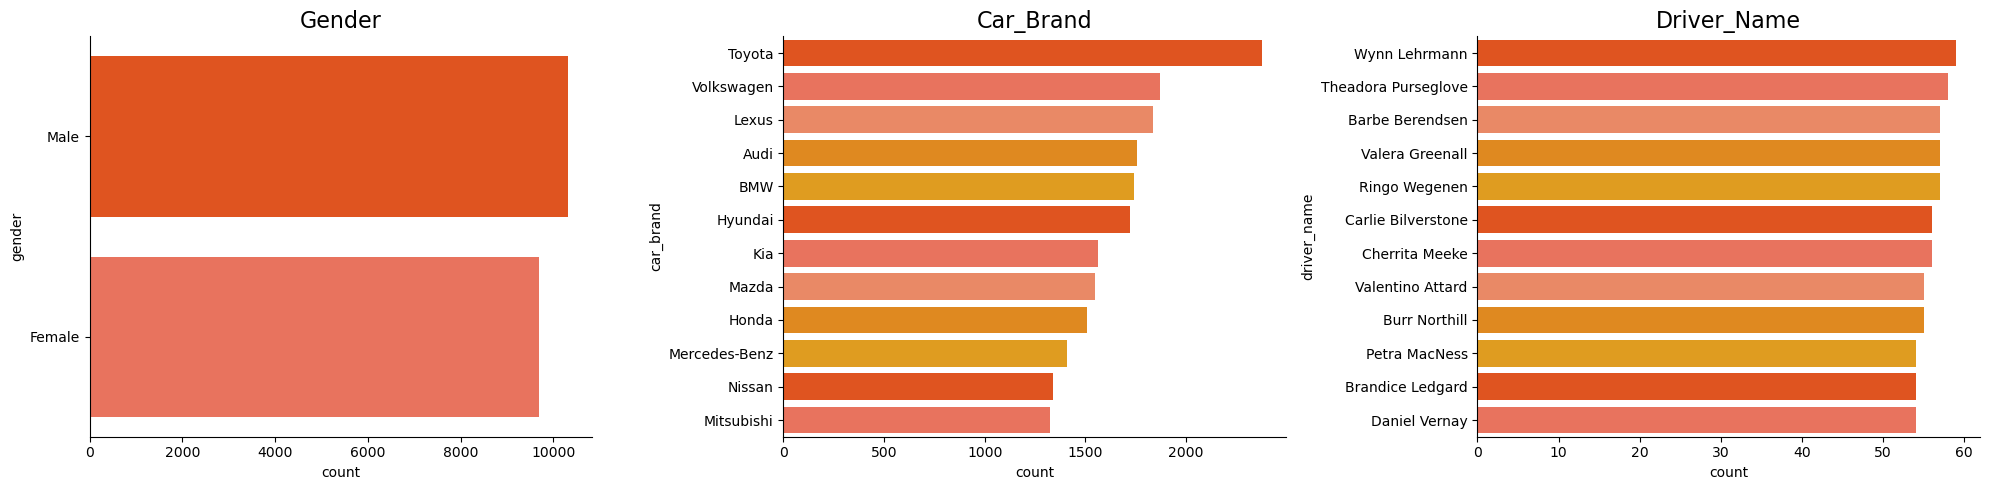

In [22]:
import warnings
warnings.filterwarnings('ignore')
grouped_df = df_new.groupby('bookingID').first() # group by bookingID and get the first row of each group

categorical_columns = ['gender', 'car_brand','driver_name']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(y=col, data=grouped_df, ax=axes[i], palette=palette, order=grouped_df[col].value_counts().index[:12])
    axes[i].set_title(f'{col.title()}', fontsize=16)

    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].grid(False) 
    
plt.tight_layout()
plt.show()

### Target Label

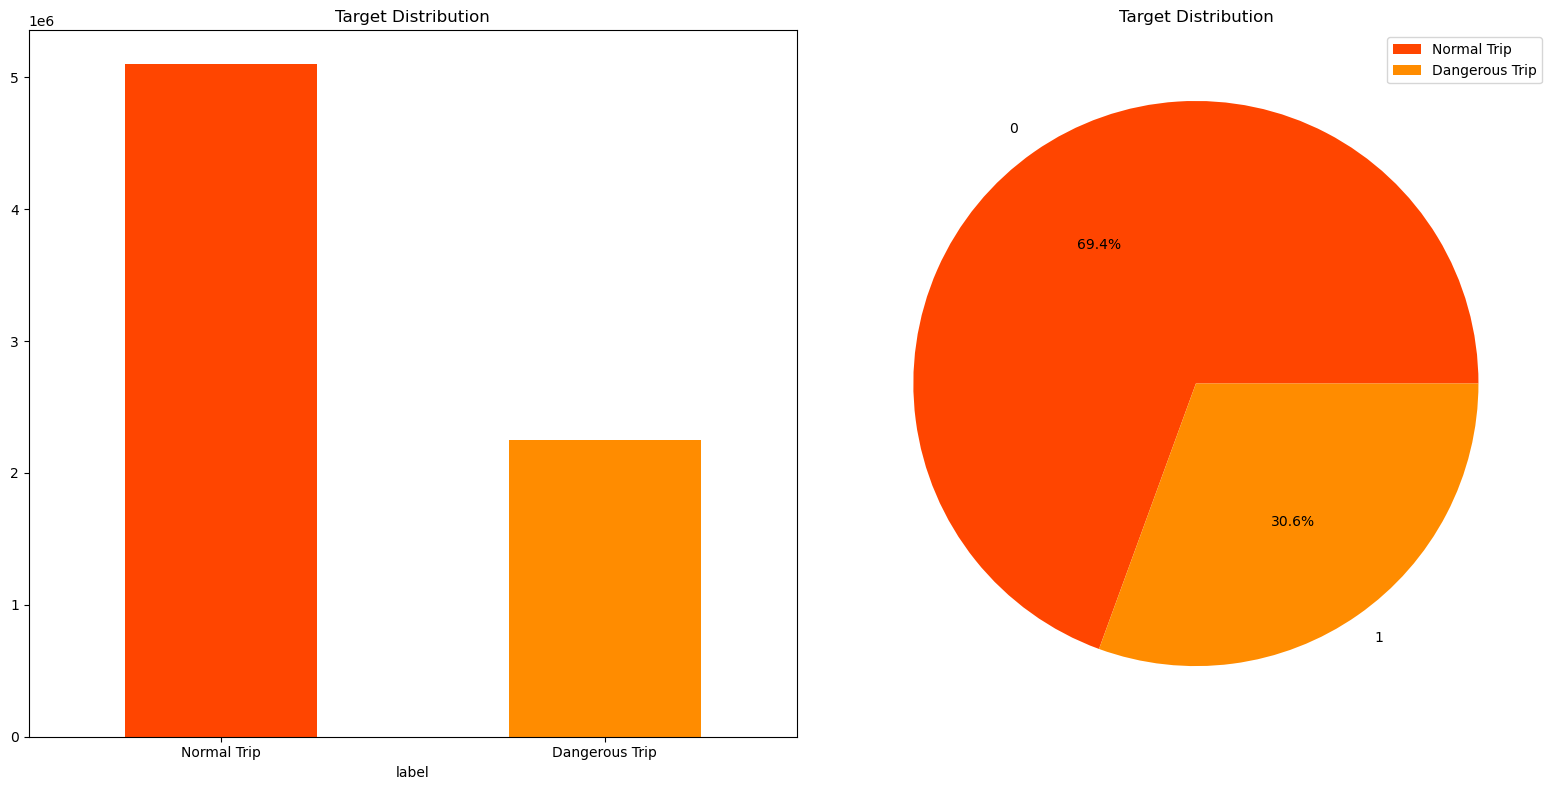

In [30]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 8))
colours = [
'#FF4500',
'#FF8C00'
]
df_new["label"].value_counts().plot(kind='bar', ax=ax, title="Target Distribution",color=colours)
ax.set_xticklabels(('Normal Trip','Dangerous Trip'), rotation=360)

df_new["label"].value_counts().plot(kind='pie', ax=ax1, title="Target Distribution", autopct='%1.1f%%',colors=colours)
ax1.legend(('Normal Trip','Dangerous Trip'))
ax1.set_ylabel('')

plt.tight_layout()
plt.show()

Observations:
-  Our df is imbalance, with Dangerous Trips (labelled : 1) having half the amount as Normal trips. This suggests that we may need to use oversampling techniques for our df when building a machine learning model.
- This class imbalance is a good thing for the company, as it shows its drivers as generally careful in their driving. With 30.6% of it being dangerous

### Continous Variables

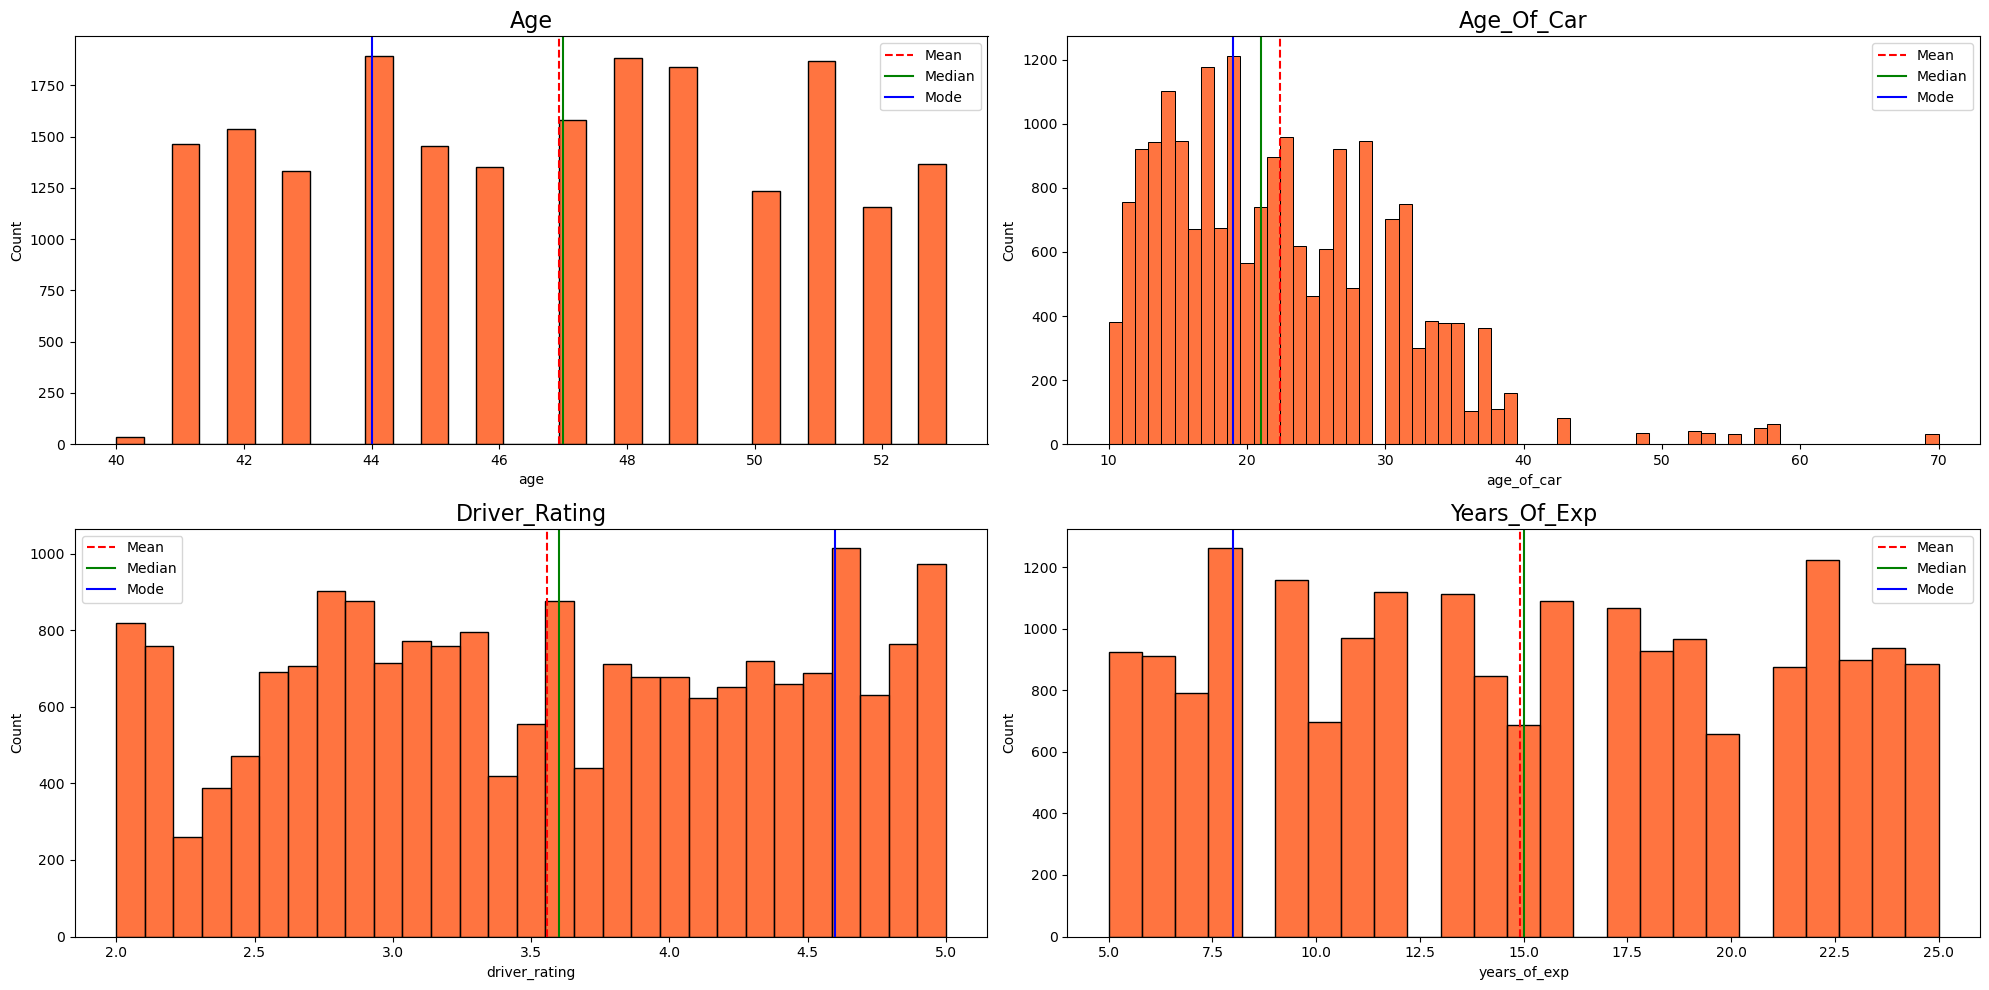

In [77]:
continuous_variables = ['age', 'age_of_car', 'driver_rating', 'years_of_exp']

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_variables):
    sns.histplot(x=col, data=grouped_df, ax=axes[i], color=palette[0])
    axes[i].set_title(f'{col.title()}', fontsize=16)
    
    mean = grouped_df[col].mean()
    median = grouped_df[col].median()
    mode = grouped_df[col].mode().get(0, None)

    axes[i].axvline(mean, color='r', linestyle='--')
    axes[i].axvline(median, color='g', linestyle='-')
    if mode is not None:
        axes[i].axvline(mode, color='b', linestyle='-')

    axes[i].legend({'Mean': mean,'Median': median,'Mode': mode})

plt.tight_layout()
plt.show()

### Correlation Matrix

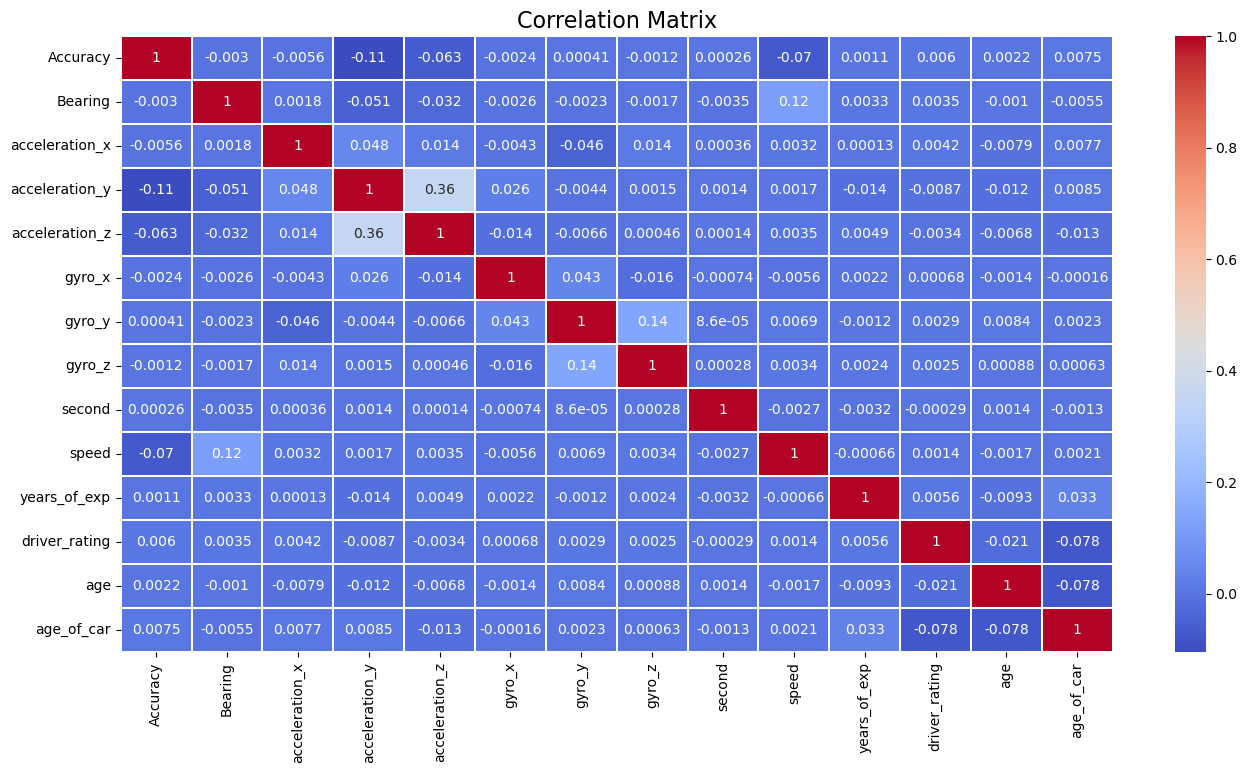

In [24]:
plt.figure(figsize=(16, 8))


sns.heatmap(df_new[continuous_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Matrix', fontsize=16)
plt.show()